In [2]:
import os
import shutil
from importlib import reload

import gpr
import cfGPR
import vonkarman as vk
import treecorr
import plotGPR

import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as c
import scipy.optimize as opt

In [3]:
reload(plotGPR)

<module 'plotGPR' from '/home/fortino/DESworkspace/plotGPR.py'>

Length  4340
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Length  4340
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Mean of first 41 points (Emode (Observed)):  392.6165228472755
Mean of first 41 points (Emode (2 Kernel)):  78.03863379522454
Mean of first 41 points (Emode (von Karman)):  299.37732366443163
Ratio of E modes (Observed / 2 Kernel): 5.0310532585374546
Ratio of E modes (Observed / von Karman): 1.311443759472426
Standard Deviation of first 41 points (Emode (Observed)):  94.65574722036118
Standard Deviation of first 41 points (Emode (2 Kernel)):  39.50287028161141
Standard Deviation of first 41 points (Emode (von Karman)):  203.63731090739861


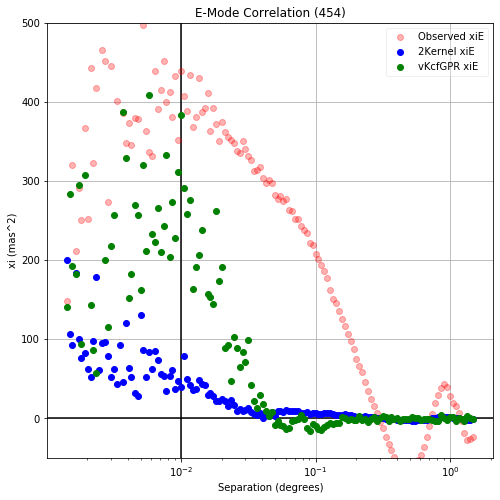

Mean of first 41 points (Bmode (Observed)):  29.48115478672032
Mean of first 41 points (Bmode (2 Kernel)):  49.766977459058864
Mean of first 41 points (Bmode (von Karman)):  290.2954103901355
Ratio of B modes (Observed / 2 Kernel): 0.5923838716340205
Ratio of B modes (Observed / von Karman): 0.10155570405711836
Standard Deviation of first 41 points (Bmode (Observed)):  201.4064767911444
Standard Deviation of first 41 points (Bmode (2 Kernel)):  134.55085736771153
Standard Deviation of first 41 points (Bmode (von Karman)):  215.81560850720126


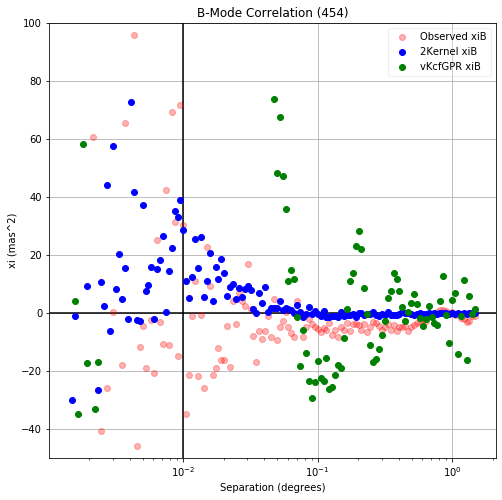

In [4]:
# Try 450, 451, 452, 465
exposure = 454

# Load cfGPR data
cfGPR_data = np.load(f'../vkexposures/{exposure}/{exposure}.npz')

# Solve for weighted and pixelized residuals, as well as angle averaged correlation function.
u, v = cfGPR_data['Xtest'][:, 0], cfGPR_data['Xtest'][:, 1]
dx, dy = cfGPR_data['Ytest'][:, 0] - cfGPR_data['fbar_s'][:, 0], cfGPR_data['Ytest'][:, 1] - cfGPR_data['fbar_s'][:, 1]
logr2, xiplus2, ximinus2, xicross2, xiz22 = cfGPR.vcorr(u, v, dx, dy)

# Calculate xiE and xiB
dlogr2 = np.zeros_like(logr2)
dlogr2[1:-1] = 0.5 * (logr2[2:] - logr2[:-2])
tmp2 = np.array(ximinus2) * dlogr2
integral2 = np.cumsum(tmp2[::-1])[::-1]
xiB2 = 0.5 * (xiplus2 - ximinus2) + integral2
xiE2 = xiplus2 - xiB2

# Load GPR data
GP = gpr.GPR('dxdy', npz=f"../exposures/{exposure}.npz")
GP.savefits('../exposures')
GP.loadfits(f'../exposures/GP{exposure}.fits', f'../exposures/{exposure}.fits')
GP.calc_EB()

# assert np.all(logr2 == GP.logr)

ind = np.sum(GP.r <= 0.01)


E_avg_obs = np.nanmean(GP.xiE[:ind])
E_avg_2k = np.nanmean(GP.GPxiE[:ind])
E_avg_vk = np.nanmean(xiE2[:ind])

E_std_obs = np.nanstd(GP.xiE[:ind])
E_std_2k = np.nanstd(GP.GPxiE[:ind])
E_std_vk = np.nanstd(xiE2[:ind])

f, ax = plt.subplots(nrows=1, ncols=1, sharey=True, figsize=(8, 8))
plt.subplots_adjust(wspace=0)

ax.set_title(f"E-Mode Correlation ({exposure})")
ax.axhline(y=0, c='k')
ax.axvline(x=0.01, c='k')

ax.semilogx(GP.r, GP.xiE, 'ro', alpha=0.3, label='Observed xiE')
ax.semilogx(GP.r, GP.GPxiE, 'bo', label='2Kernel xiE')
ax.semilogx(GP.r, xiE2, 'go', label='vKcfGPR xiE')


ax.grid()
ax.set_xlabel('Separation (degrees)')
ax.set_ylabel('xi (mas^2)')

ax.set_ylim((-50, 500))

ax.legend(framealpha=0.3)

print(f"Mean of first {ind+1} points (Emode (Observed)): ", E_avg_obs)
print(f"Mean of first {ind+1} points (Emode (2 Kernel)): ", E_avg_2k)
print(f"Mean of first {ind+1} points (Emode (von Karman)): ", E_avg_vk)

print(f"Ratio of E modes (Observed / 2 Kernel): {E_avg_obs / E_avg_2k}")
print(f"Ratio of E modes (Observed / von Karman): {E_avg_obs / E_avg_vk}")

print(f"Standard Deviation of first {ind+1} points (Emode (Observed)): ", E_std_obs)
print(f"Standard Deviation of first {ind+1} points (Emode (2 Kernel)): ", E_std_2k)
print(f"Standard Deviation of first {ind+1} points (Emode (von Karman)): ", E_std_vk)

plt.show()


B_avg_obs = np.nanmean(GP.xiB[:ind])
B_avg_2k = np.nanmean(GP.GPxiB[:ind])
B_avg_vk = np.nanmean(xiB2[:ind])

B_std_obs = np.nanstd(GP.xiB[:ind])
B_std_2k = np.nanstd(GP.GPxiB[:ind])
B_std_vk = np.nanstd(xiB2[:ind])

f, ax = plt.subplots(nrows=1, ncols=1, sharey=True, figsize=(8, 8))
plt.subplots_adjust(wspace=0)

ax.set_title(f"B-Mode Correlation ({exposure})")
ax.axhline(y=0, c='k')
ax.axvline(x=0.01, c='k')

ax.semilogx(GP.r, GP.xiB, 'ro', alpha=0.3, label='Observed xiB')
ax.semilogx(GP.r, GP.GPxiB, 'bo', label='2Kernel xiB')
ax.semilogx(GP.r, xiB2, 'go', label='vKcfGPR xiB')


ax.grid()
ax.set_xlabel('Separation (degrees)')
ax.set_ylabel('xi (mas^2)')

ax.set_ylim((-50, 100))

ax.legend(framealpha=0.3)

print(f"Mean of first {ind+1} points (Bmode (Observed)): ", B_avg_obs)
print(f"Mean of first {ind+1} points (Bmode (2 Kernel)): ", B_avg_2k)
print(f"Mean of first {ind+1} points (Bmode (von Karman)): ", B_avg_vk)

print(f"Ratio of B modes (Observed / 2 Kernel): {B_avg_obs / B_avg_2k}")
print(f"Ratio of B modes (Observed / von Karman): {B_avg_obs / B_avg_vk}")

print(f"Standard Deviation of first {ind+1} points (Bmode (Observed)): ", B_std_obs)
print(f"Standard Deviation of first {ind+1} points (Bmode (2 Kernel)): ", B_std_2k)
print(f"Standard Deviation of first {ind+1} points (Bmode (von Karman)): ", B_std_vk)

plt.show()